<a href="https://colab.research.google.com/github/woncoh1/END/blob/main/Assignment_Session_3x_EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

1. Make a network that has:
  1. **6** convolution layers with these kernels (**10, 10, 20, 20, 30**)
  2. **No fully connected** layer (you probably may have to use the **Global Average Pooling** layer)
  3. Uses **EMNIST** as the dataset
  4. Uses a **maximum of 2 max-pooling** layers
2. Your code MUST be:
  1. **Well documented**
  2. Must mention the **receptive field calculations** (as we discussed in the class)
  3. Must mention the **input and output size** for each layer
  4. Must be trained for **minimum of 20 epochs**
  5. Training MUST happen on the **GPU**
3. Once done, upload the code with **training logs** from colab to GitHub, and share the **GitHub** link

# 1. Prepare data

In [ ]:
import torch
import torchvision # provide access to datasets, transforms, models, utils, etc
import torchvision.transforms as transforms

### Download datasets

In [ ]:
# download training and testing datasets

train_set = torchvision.datasets.EMNIST(
    root = './data',
    split = 'byclass',
    train = True,
    download = True,
    transform = transforms.Compose([
        # map values from [0, 255] to [0, 1]   
        # by converting array to tensor, and then dividing by 255                         
        transforms.ToTensor() 
    ]))

test_set = torchvision.datasets.EMNIST(
    root = './data',
    split = 'byclass',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ]))

### Inspect datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

**Training set**

In [ ]:
# size of training set

len(train_set)

697932

In [ ]:
# range of label values

train_set.train_labels.min(), train_set.train_labels.max()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


(tensor(0), tensor(61))

In [ ]:
# frequency of each label

train_set.train_labels.bincount() 

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([34585, 38374, 34203, 35143, 33535, 31416, 34232, 35754, 33946, 33847,  6407,  3878, 10094,  4562,  4934,  9182,
         2517,  3152, 11946,  3762,  2468,  5076,  9002,  8237, 24983,  8347,  2605,  5073, 20764,  9820, 12602,  4637,
         4695,  2771,  4743,  2701, 10033,  5159,  2854, 10177, 24631,  2561,  3687,  8738,  2725,  1896,  2491, 15318,
         2645, 11418,  2749,  2448,  2994, 14105,  2699, 18262,  2830,  2910,  2697,  2822,  2365,  2725])

In [ ]:
# sample from the training set

sample = next(iter(train_set))

len(sample), type(sample)

(2, tuple)

In [ ]:
# separate image and label from sample

image, label = sample

image.shape, label

(torch.Size([1, 28, 28]), 35)

label: 35


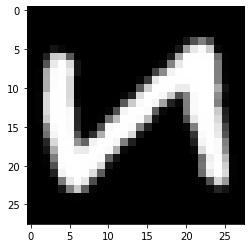

In [ ]:
# view image

plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

### Make batches

In [ ]:
# make training and testing batches

torch.manual_seed(1) # for reproducibility
BATCH_SIZE = 128

# GPU configurations for data loaders
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# shuffle to 1) prevent model from learning image orders, and
#            2) assure equal distribution of classes
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs) 

test_loader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs)

## Inspect batches

**Training batch**

In [ ]:
# sample a training batch

batch = next(iter(train_loader))

len(batch), type(batch)

(2, list)

In [ ]:
# separate images from labels

images, labels = batch

labels: tensor([53, 24, 24,  5,  6, 49,  1, 29,  3, 28, 39, 22, 40, 40, 32,  3, 20,  6,  0,  8,  0, 39, 20, 45, 55, 47,  5, 39,
         1,  9,  0, 24, 24, 36,  0,  8,  8, 39,  6,  2,  4,  9,  7, 14,  6,  1, 40, 24, 10, 27, 55, 53,  4, 32,  7,  9,
        40, 43,  5, 24,  9,  6,  4,  0, 20, 14,  8,  6,  4,  2,  2, 29, 24, 36,  1, 34,  8, 18, 28,  6,  6, 30, 55, 55,
        39, 48,  2, 49, 32, 29,  4, 25,  8, 47, 22, 28, 58, 42, 28,  7, 29, 50, 25, 38, 28, 36,  1,  1, 48, 38, 24,  2,
         8, 53,  9,  7, 15,  9, 32, 37,  0, 39, 21,  2, 55, 12, 55,  5])


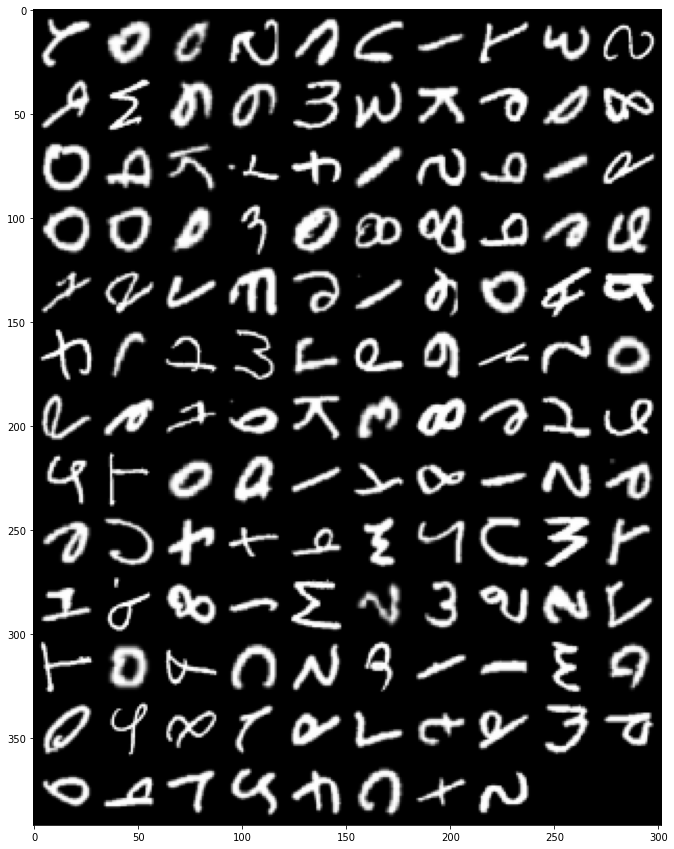

In [ ]:
# view grid of images

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

# 2. Build model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# define model structure

class Network(nn.Module):

    # Parts list describing building blocks
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, 
                               kernel_size=3, padding=1)        # Input: 28 x 28 x 1 , Kernel: 3 x 3 x 1 , Output: 28 x 28 x 10, RF:  3 x 3
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, 
                               kernel_size=3, padding=1)        # Input: 28 x 28 x 10, Kernel: 3 x 3 x 10, Output: 28 x 28 x 10, RF:  5 x 5
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)      # Input: 28 x 28 x 10, Kernel: 2 x 2 x 1 , Output: 14 x 14 x 10, RF: 10 x 10
        
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, 
                               kernel_size=3, padding=0)        # Input: 14 x 14 x 10, Kernel: 3 x 3 x 10, Output: 12 x 12 x 20, RF: 12 x 12
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, 
                               kernel_size=3, padding=0)        # Input: 12 x 12 x 20, Kernel: 3 x 3 x 20, Output: 10 x 10 x 20, RF: 14 x 14
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)      # Input: 10 x 10 x 20, Kernel: 2 x 2 x 1 , Output:  5 x 5  x 20, RF: 28 x 28
        
        self.conv5 = nn.Conv2d(in_channels=20, out_channels=30, 
                               kernel_size=3, padding=0)        # Input:  5 x 5  x 20, Kernel: 3 x 3 x 20, Output:  3 x 3  x 30, RF: 30 x 30
        self.conv6 = nn.Conv2d(in_channels=30, out_channels=62, 
                               kernel_size=3, padding=0)        # Input:  3 x 3  x 30, Kernel: 3 x 3 x 30, Output:  1 x 1  x 62, RF: 32 x 32

    # Step-by-step manual for assembling building blocks 
    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.conv6(F.relu(self.conv5(x))) # conv6 is the CEO, so no ReLU
        x = x.view(-1, 62) # flatten for softmax
        return F.log_softmax(x, dim=1)

In [ ]:
# Instantiate model into device and
# view model summary

!pip install torchsummary
from torchsummary import summary

device = torch.device("cuda" if use_cuda else "cpu")
model = Network().to(device)
summary(model, input_size=(1, 28, 28)) # default input size of MNIST dataset

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
            Conv2d-2           [-1, 10, 28, 28]             910
         MaxPool2d-3           [-1, 10, 14, 14]               0
            Conv2d-4           [-1, 20, 12, 12]           1,820
            Conv2d-5           [-1, 20, 10, 10]           3,620
         MaxPool2d-6             [-1, 20, 5, 5]               0
            Conv2d-7             [-1, 30, 3, 3]           5,430
            Conv2d-8             [-1, 62, 1, 1]          16,802
Total params: 28,682
Trainable params: 28,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.11
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


# 3. Train the model

In [ ]:
# Optimize model parameters

def train(model: 'neural network', 
          device: 'CPU or GPU', 
          train_loader: 'training batch', 
          optimizer: 'weight-optimizing algorithm', 
          epochs: 'how many cycles of consuming the entire batches'):
    
    # set model to train mode, enabling features like regularization
    model.train() 
    
    # iterator for all epochs
    for epoch in range(epochs):

      # iteratively accumulate test loss and # of correct predictions
      train_loss = 0
      correct = 0

      # iterate for every batch
      for data, target in train_loader:

          # instantiate data and target to device
          data, target = data.to(device), target.to(device) 
          
          # zero previously accumulated gradients for mini-batch update
          optimizer.zero_grad()
          # forward pass
          output = model(data)
          # define loss function
          loss = F.nll_loss(output, target) 
          # calculate gradients 
          loss.backward() 
          # update parameters
          optimizer.step() 

          # sum up batch loss
          train_loss += loss.sum().item()
          # get the index of the max log-probability
          pred = output.argmax(dim=1, keepdim=True)
          # update # of correct predictions  
          correct += pred.eq(target.view_as(pred)).sum().item()

      # average train loss per batch
      train_loss /= len(train_loader.dataset)   

      print('Train set: Epoch: {} | Average loss: {:.4f} | Accuracy: {}/{} ({:.0f}%)\n'.format(
          epoch + 1, # current epoch
          train_loss, # training loss
          correct, len(train_loader.dataset), # accuracy
          100. * correct / len(train_loader.dataset)))

In [ ]:
# Test how well model parameters are optimized

def test(model, device, test_loader: 'testing batch'):
    
    # set model to evaluation mode, disabling features like regularization
    model.eval()
   
    # iteratively accumulate test loss and # of correct predictions
    test_loss = 0
    correct = 0
    
    # do not calculate gradients (saves memory)
    with torch.no_grad():
        # iterate for every batch
        for data, target in test_loader:
            
            # instantiate data and target to device
            data, target = data.to(device), target.to(device)
            # forward pass
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # update # of correct predictions  
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # average test loss per batch
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f} | Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, # testing loss
        correct, len(test_loader.dataset), # accuracy
        100. * correct / len(test_loader.dataset)))

In [ ]:
# Instantiate optimizer

import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Bring batches, model, loss function and optimizer together to actually
# carry out training and testing of the model

epoch = 20

train(model, device, train_loader, optimizer, epoch)

test(model, device, test_loader)

Train set: Epoch: 1 | Average loss: 0.0050 | Accuracy: 554070/697932 (79%)

Train set: Epoch: 2 | Average loss: 0.0034 | Accuracy: 589228/697932 (84%)

Train set: Epoch: 3 | Average loss: 0.0032 | Accuracy: 594274/697932 (85%)

Train set: Epoch: 4 | Average loss: 0.0031 | Accuracy: 597361/697932 (86%)

Train set: Epoch: 5 | Average loss: 0.0030 | Accuracy: 598830/697932 (86%)

Train set: Epoch: 6 | Average loss: 0.0030 | Accuracy: 600232/697932 (86%)

Train set: Epoch: 7 | Average loss: 0.0030 | Accuracy: 601051/697932 (86%)

Train set: Epoch: 8 | Average loss: 0.0029 | Accuracy: 601882/697932 (86%)

Train set: Epoch: 9 | Average loss: 0.0029 | Accuracy: 602618/697932 (86%)

Train set: Epoch: 10 | Average loss: 0.0029 | Accuracy: 602897/697932 (86%)

Train set: Epoch: 11 | Average loss: 0.0029 | Accuracy: 603653/697932 (86%)

Train set: Epoch: 12 | Average loss: 0.0028 | Accuracy: 603715/697932 (87%)

Train set: Epoch: 13 | Average loss: 0.0028 | Accuracy: 604290/697932 (87%)

Train se